# Total Mainnet Transaction Analysis

In [1]:
import json
import pandas as pd
import numpy as np
import datetime
import plotly.express as px 
import plotly.graph_objects as go
from IPython.core.display import display, HTML
import os
from os import path
from collections import defaultdict
import pickle

In [2]:
def is_json(myjson):
    try:
        json_object = json.loads(myjson)
    except ValueError as e:
        return False
    return True

In [3]:
def read_data(path):
    data = []
    with open(path, errors='ignore') as f:
        for line in f.readlines():
            try: 
                if not is_json(line):
                    continue
                data.append(json.loads(line))
            except:
                print('bad json: ', line)
    return data

In [4]:
def draw_graph(df, feature, name):
    html_path = "https://harmony-one.github.io/harmony-log-analysis/" + html_dir.replace("../../../docs/", "")
    fig = px.line(df, x='timestamp', y=feature, color='shard', color_discrete_sequence=px.colors.qualitative.Pastel,\
                      title = '{:s} vs UTC Time'.format(name))
    fig.update_layout(xaxis_title="utc_time")
    if len(df.groupby('shard')['shard'].count()) == 1:
        fig.update_layout(showlegend=False)
    fig.show(renderer="svg",width=800, height=500)
    fig.write_html("{:s}{:s}_vs_utc_time.html".format(html_dir,feature))
    print("HTML saved in " )
    display_path = "{:s}{:s}_vs_utc_time.html".format(html_path,feature)
    display(HTML("<a href='" + display_path + "' target='_blank'>" + display_path + "</a>"))

## before 2020-05-06

In [5]:
data = read_data("../logs/mainnet_2020_05_06.log")
df = pd.DataFrame(data)
df['timestamp'] = pd.to_datetime(df['timestamp'], format = '%Y_%m_%d %H:%M:%S')
df['date'] = df['timestamp'].apply(lambda c: c.date().strftime('%Y-%m-%d'))
df.sort_values(by=['timestamp'], inplace = True)

In [6]:
new = df.groupby(['date','shard']).tail(1).reset_index(drop = True)
total = new.groupby('date')['shard-transactions'].sum()
total = pd.DataFrame(total)
total.rename(columns={"shard-transactions": "total-transactions"}, inplace=True)
new = new.join(total, on = 'date')
new.sort_values(by=['timestamp'], inplace = True)


In [7]:
daily = new.groupby('date').tail(1).reset_index(drop = True)
daily['daily-transactions'] = (daily['total-transactions']-daily['total-transactions'].shift()).fillna(0).astype(int)
daily = daily[daily['timestamp'] < '2020-05-07']
daily['shard'] = "all-shards"

## after 2020-05-06

In [8]:
log_dir = "/home/ubuntu/jupyter/monitor/mini_explorer/data/"
json_dir = "/home/ubuntu/jupyter/harmony-log-analysis/projects/ONE_holder/credential"
files = os.listdir(log_dir)

data = path.abspath(path.join("..", 'pickle'))
if not path.exists(data):
    try:
        os.mkdir(data)
    except:
        print("Could not make data directory")
        exit(1)

txs_file = path.join(data,'txs_daily_count.pkl')
if path.exists(txs_file):
    with open(txs_file, 'rb') as f:
         txs_daily = pickle.load(f)
else: 
    txs_daily = defaultdict(int)
    for file in files:
        if ".log" not in file and file != "mainnet_2020_05_06" and file != ".ipynb_checkpoints":
            date = file[8:]
            data = read_data(log_dir+file)
            df = pd.DataFrame(data) 
            txs = sum(df['transactions'])
            txs_daily[date] = txs
    with open(txs_file, 'wb') as f:
        pickle.dump(txs_daily, f)


In [9]:
txs_df = pd.DataFrame(txs_daily.items(), columns=['date', 'txs-count'])  
txs_df['date'] = pd.to_datetime(txs_df['date'], format='%Y%m%d')

## merge two data source

In [10]:
daily['date'] = pd.to_datetime(daily['timestamp'].dt.date, format = '%Y-%m-%d')
old_df = daily[['date', 'daily-transactions']]
old_df = old_df.rename(columns = {'daily-transactions': 'txs-count'})
new_df = pd.concat([old_df, txs_df], axis=0)
new_df.sort_values(by=['date'], inplace = True)
new_df.reset_index(drop = True, inplace = True)
new_df = new_df[new_df['date'] < '2020-07-01']

In [11]:
html_dir = "../../../docs/graphs/transactions/"
if not path.exists(html_dir):
    try:
        os.makedirs(html_dir)
    except:
        print("Could not make directory")
        exit(1)

## shard Transactions Change

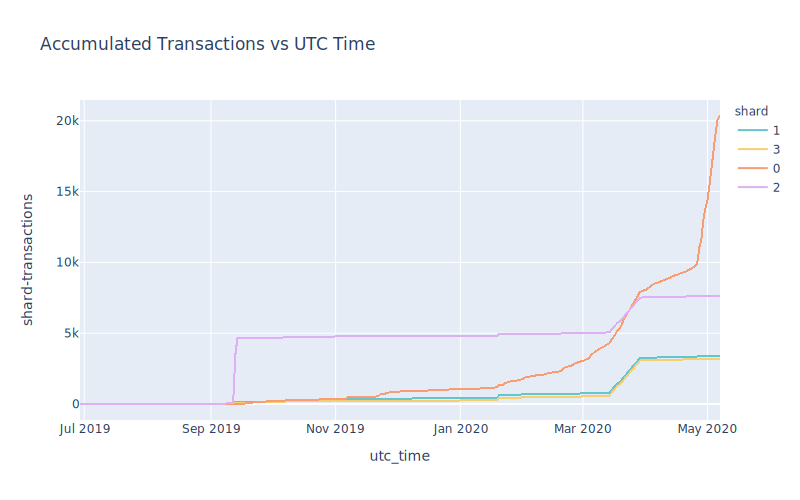

HTML saved in 


In [12]:
draw_graph(new, 'shard-transactions', "Accumulated Transactions")

## Total Transaction Visualization

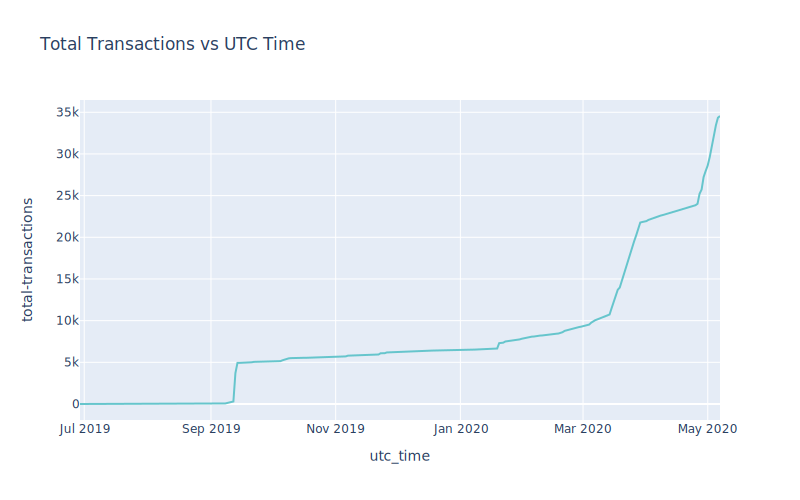

HTML saved in 


In [13]:
draw_graph(daily, 'total-transactions', "Total Transactions")

## Daily Transactions Visualization

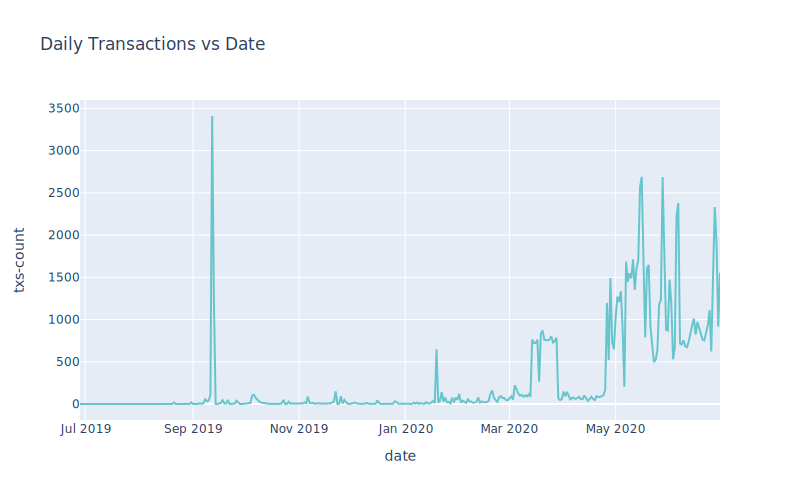

HTML saved in 


In [16]:
# draw_graph(daily, 'daily-transactions', "Daily Transactions")
html_path = "https://harmony-one.github.io/harmony-log-analysis/" + html_dir.replace("../../../docs/", "")
fig = px.line(new_df, x='date', y='txs-count', color_discrete_sequence=px.colors.qualitative.Pastel,\
                  title = 'Daily Transactions vs Date')

fig.show(renderer="svg",width=800, height=500)
fig.write_html("{:s}daily_transactions_vs_date.html".format(html_dir))
print("HTML saved in " )
display_path = "{:s}daily_transactions_vs_date.html".format(html_path)
display(HTML("<a href='" + display_path + "' target='_blank'>" + display_path + "</a>"))